In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_12624\218710433.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]


In [7]:
# feature engineer new living area
df['TotalLivArea'] = df.GrLivArea + df.TotalBsmtSF - df.BsmtUnfSF

In [9]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [10]:
# feature engineer new room metric
df['TotalRooms'] = df.BedroomAbvGr + df.KitchenAbvGr + df.FullBath + df.HalfBath + df.BsmtFullBath + df.BsmtHalfBath

In [11]:
df = df[['OverallQual', 'OverallCond', 'TotalLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'SaleCondition', 'Neighborhood', 'SalePrice', 'MasVnrType', 'TotalRooms']]
df.head()

,OverallQual,OverallCond,TotalLivArea,TotRmsAbvGrd,YearBuilt,SaleCondition,Neighborhood,SalePrice,MasVnrType,TotalRooms
0,7,5,2416,8,2003,Normal,CollgCr,208500,BrkFace,8
1,6,8,2240,6,1976,Normal,Veenker,181500,NaN,7
2,7,5,2272,6,2001,Normal,CollgCr,223500,BrkFace,8
3,7,5,1933,7,1915,Abnorml,Crawfor,140000,NaN,6
4,8,5,2853,9,2000,Normal,NoRidge,250000,BrkFace,9


In [12]:
# drop Blueste Neighborhood (which has only two values and a weird outlier)
print(len(df))
df.drop(df[df['Neighborhood'] == 'Blueste'].index, inplace=True)
print(len(df))

1456
1454


C:\Users\johbr\AppData\Local\Temp\ipykernel_12624\1831301792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['Neighborhood'] == 'Blueste'].index, inplace=True)


In [13]:
# drop unusual sale conditions
print(len(df))
df = df[df['SaleCondition'] == 'Normal']
print(len(df))

1454
1195


In [14]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,TotalLivArea,TotRmsAbvGrd,YearBuilt,SalePrice,TotalRooms,SaleCondition_Normal,Neighborhood_Blmngtn,Neighborhood_BrDale,...,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone
0,7,5,2416,8,2003,208500,8,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,6,8,2240,6,1976,181500,7,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,7,5,2272,6,2001,223500,8,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,8,5,2853,9,2000,250000,9,True,False,False,...,False,False,False,False,False,False,False,False,True,False
5,5,5,2094,5,1993,143000,5,True,False,False,...,False,False,False,False,False,False,False,False,False,False


SalePrice               1.000000
OverallQual             0.792207
TotalLivArea            0.771283
TotRmsAbvGrd            0.528494
TotalRooms              0.505795
YearBuilt               0.504184
Neighborhood_NoRidge    0.368556
Neighborhood_NridgHt    0.322167
MasVnrType_BrkFace      0.250914
MasVnrType_Stone        0.238921
Neighborhood_StoneBr    0.155010
Neighborhood_Timber     0.145744
Neighborhood_Somerst    0.131268
Neighborhood_CollgCr    0.098121
Neighborhood_ClearCr    0.097717
Neighborhood_Veenker    0.091102
Neighborhood_Crawfor    0.085845
Neighborhood_NWAmes     0.066824
Neighborhood_SawyerW    0.051623
Neighborhood_Gilbert    0.051341
Neighborhood_Blmngtn    0.021119
MasVnrType_BrkCmn      -0.018846
Neighborhood_NPkVill   -0.038497
OverallCond            -0.050749
Neighborhood_Mitchel   -0.054602
Neighborhood_SWISU     -0.070779
Neighborhood_BrDale    -0.099464
Neighborhood_MeadowV   -0.130410
Neighborhood_Sawyer    -0.136080
Neighborhood_IDOTRR    -0.154211
Neighborho

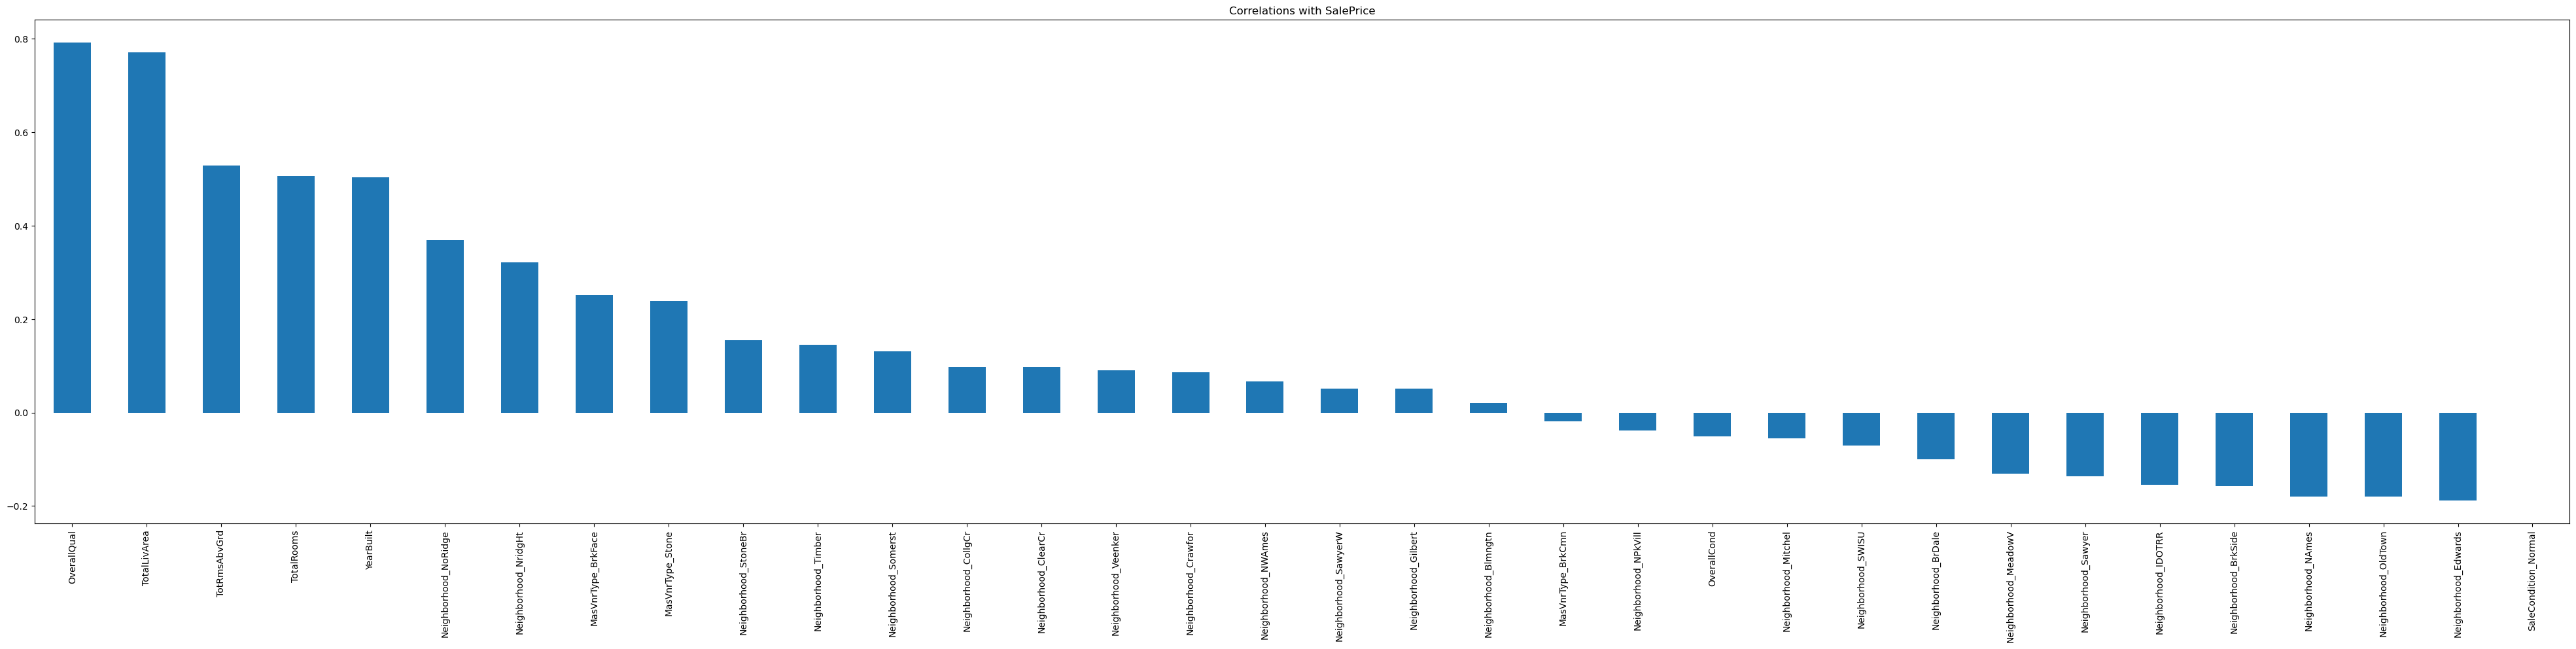

<Figure size 4000x1000 with 0 Axes>

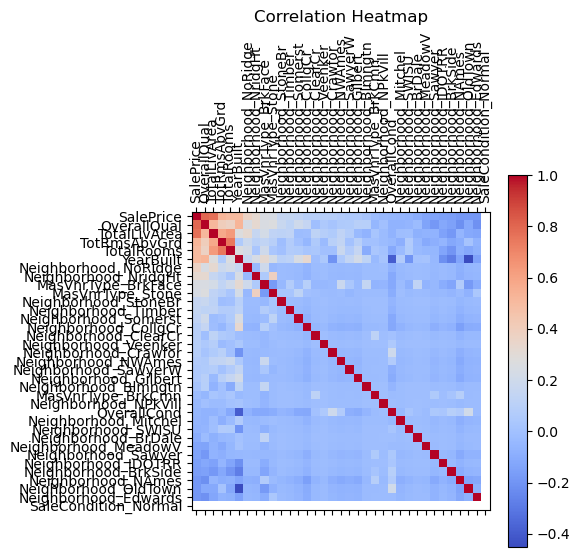

In [15]:
# calculate correlations
correlations = dummies.corr()['SalePrice'].sort_values(ascending=False)

# disable pandas display truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print correlations
print(correlations)

# reset pandas truncation
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# plot correlations bar chart
plt.figure(figsize=(50, 10))
correlations.drop('SalePrice').plot(kind='bar')
plt.title('Correlations with SalePrice')
plt.show()

# convert correlations to a DataFrame for the heatmap
correlations_df = dummies[correlations.index].corr()

# plot a heatmap of correlations
plt.figure(figsize=(40, 10))
plt.matshow(correlations_df, cmap='coolwarm')
plt.xticks(range(len(correlations_df.columns)), correlations_df.columns, rotation=90)
plt.yticks(range(len(correlations_df.columns)), correlations_df.columns)
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

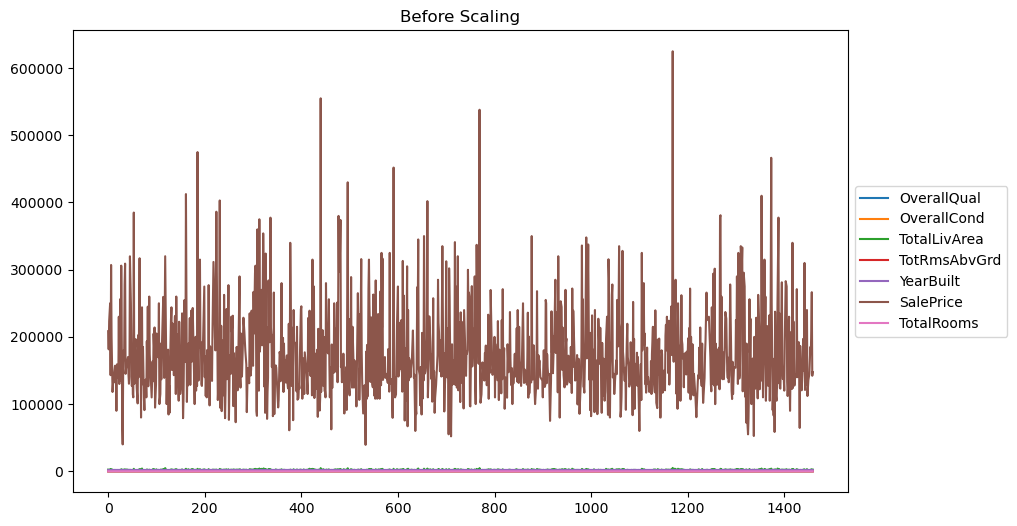

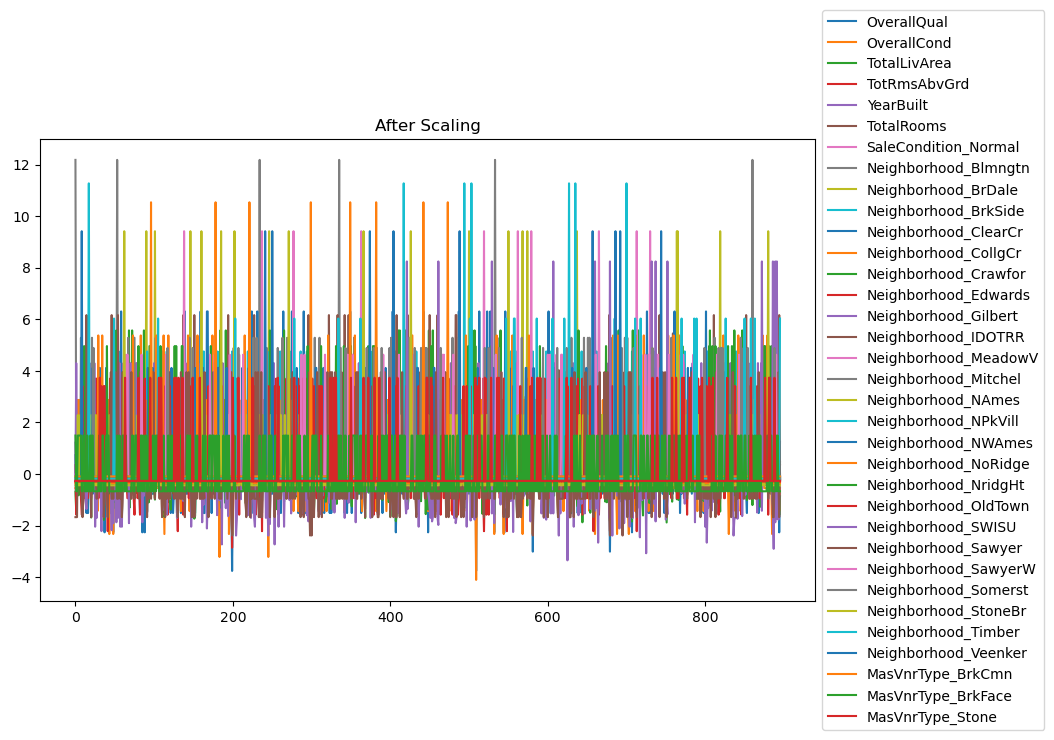

In [17]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Compile, Train, Evaluate the Model

In [18]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=4, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=50, max_value=600, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [19]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 22s]
mae: 15134.6083984375

Best mae So Far: 15134.6083984375
Total elapsed time: 00h 03m 54s


In [20]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 09 summary
Hyperparameters:
num_layers: 2
layer0: 268
activation0: relu
layer1: 410
activation1: LeakyReLU
layer2: 238
activation2: LeakyReLU
Score: 15134.6083984375

Trial 08 summary
Hyperparameters:
num_layers: 2
layer0: 366
activation0: LeakyReLU
layer1: 454
activation1: relu
layer2: 276
activation2: LeakyReLU
Score: 15612.0517578125

Trial 03 summary
Hyperparameters:
num_layers: 2
layer0: 118
activation0: LeakyReLU
layer1: 50
activation1: relu
Score: 19582.55859375

Trial 04 summary
Hyperparameters:
num_layers: 3
layer0: 588
activation0: relu
layer1: 298
activation1: tanh
layer2: 50
activation2: relu
Score: 72844.0546875

Trial 00 summary
Hyperparameters:
num_layers: 1
layer0: 564
activation0: relu
Score: 149598.90625

Trial 06 summary
Hyperparameters:
num_layers: 1
layer0: 386
activation0: relu
layer1: 360
activation1: relu
layer2: 410
activation2: relu
Score: 157950.

In [21]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 2, 'layer0': 268, 'activation0': 'relu', 'layer1': 410, 'activation1': 'LeakyReLU', 'layer2': 238, 'activation2': 'LeakyReLU'}
---
Epoch 1/100
28/28 [==============================] - 2s 15ms/step - loss: 176375.8438 - mae: 176375.8438 - val_loss: 164027.2969 - val_mae: 164027.2969
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 176293.1406 - mae: 176293.1406 - val_loss: 163878.5469 - val_mae: 163878.5469
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 176043.6250 - mae: 176043.6250 - val_loss: 163482.3750 - val_mae: 163482.3750
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 175458.5938 - mae: 175458.5938 - val_loss: 162641.4219 - val_mae: 162641.4219
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 174321.5000 - mae: 174321.5000 - val_loss: 161128.1094 - val_mae: 161128.1094
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 172

In [22]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 268)               9380      
                                                                 
 dense_4 (Dense)             (None, 410)               110290    
                                                                 
 dense_5 (Dense)             (None, 1)                 411       
                                                                 
Total params: 120081 (469.07 KB)
Trainable params: 120081 (469.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[ 0.8530396   0.91626173 -0.05992745 ...  1.1253686   0.93913496
   0.01330959]
 [ 0.18417543  0.5695657   0.7903864  ...  0.5212183   0.4908507
   0.19643949]
 [ 0.9113655   1.1479974  -0.18451954 ...  1.3403455   0.3574987
   0.23233935]
 ...
 [ 0.08082293 -1.22493     0.33029234 ... -1.150193   -1.1576608
  -1.1851622 ]
 [-0.0889796   0.559975   -0.50962055 ...  0.08672873  0.02425485
  -0.5821948 ]
 [ 0.40374    -1.0462979  -0.5080665  ... -0.28448626 -0.1291458
  -0.23981996]]
Layer 1 Weights:
[1.0705515  1.1736679  1.0367383  1.0184118  1.0968775  1.1126612
 1.0131714  1.1197612  0.99352485 1.1023712  1.139483   1.1514907
 1.1312561  1.0913075  1.097929   1.0512222  1.0416373  1.0148575
 1.0576631  1.0538614  1.0362736  1.0758715  1.067443   1.0870553
 1.0132056  1.1206021  1.0167564  1.1296262  1.0731249  1.0147457
 1.0329018  1.020891   1.035639   1.0688015  1.010082   1.0770091
 1.1037266  1.0417459  0.96705896 1.0171393  1.0344561  1.0559076
 1.1011738  1.07

In [24]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


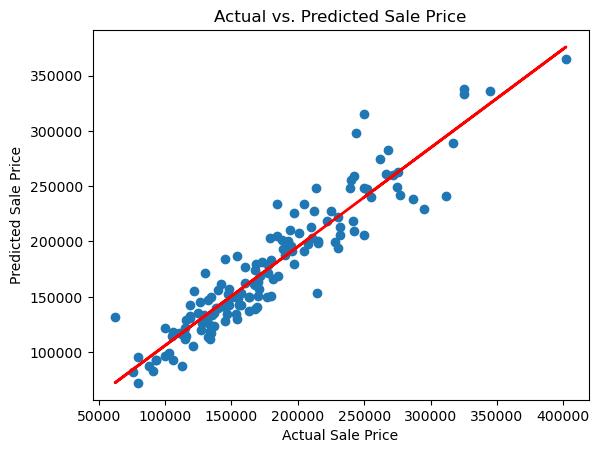

In [25]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [26]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.8760999367101603
Mean Squared Error: 453689530.5460807
Mean Absolute Error: 15383.4996875
Mean Percentage Error: -10.774950969776619


In [27]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -9.767483872025196e-05
Baseline Mean Squared Error: 3662095341.601121
Baseline Mean Absolute Error: 48139.728422619046
Mean Percentage Error: -12.500385305330964


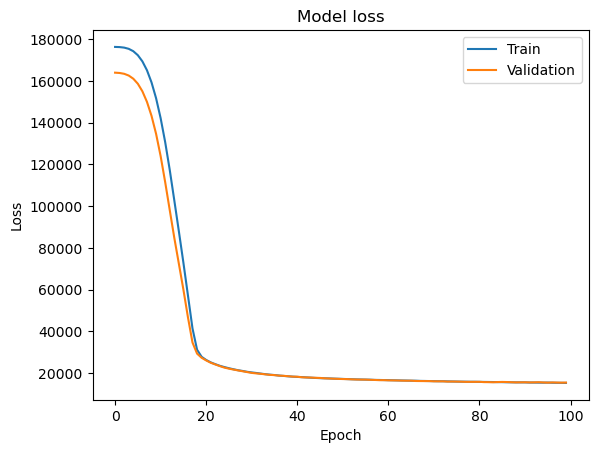

In [28]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

5/5 [==============================] - 0s 3ms/step


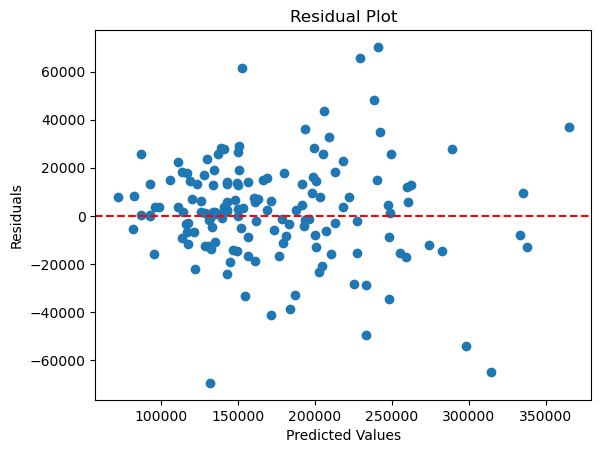

In [29]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

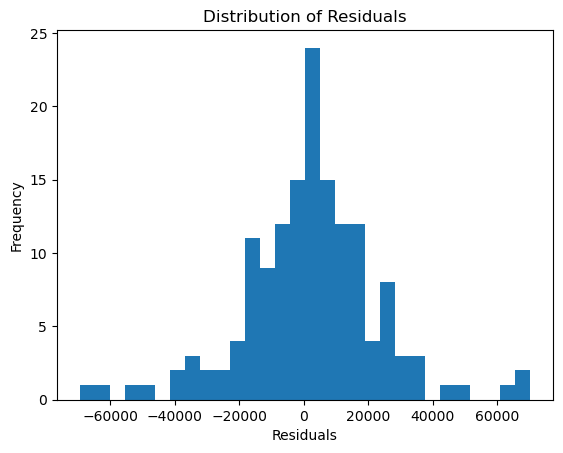

In [30]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [31]:
# plot the learning curve?